In [6]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings('ignore')
ds_hmeq = pd.read_csv("./HMEQ.CSV",engine="python")
ds_hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [8]:
# JOB의 결측치는 Other로 메꾼 후에 ds_hmeq데이터에 저장. inplace=false:저장안함
ds_hmeq["JOB"].fillna("Other", inplace=True)
# 숫자변수 결측치 mean으로 각 변수별 평균 계산 후 결측치 대체 
ds_hmeq.fillna(ds_hmeq.mean(),inplace=True)

In [9]:
# get_dummies: 데이터의 문자형 컬럼에 대한 더미변수 생성
ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
ds_hmeq_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [10]:
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
ds_hmeq_train = ds_hmeq_dummy[msk]
ds_hmeq_test = ds_hmeq_dummy[~msk]

# train/test 데이터의 목표변수/설명변수 지정
ds_hmeq_train_y = ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD", axis=1, inplace=False)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD", axis=1, inplace=False)

# train데이터와 test데이터 크기
print("train data X size: {}".format(ds_hmeq_train_x.shape))
print("train data Y size: {}".format(ds_hmeq_train_y.shape))
print("test data X size: {}".format(ds_hmeq_test_x.shape))
print("test data Y size: {}".format(ds_hmeq_test_y.shape))

# train data: 2604, test data: 1144

train data X size: (2604, 18)
train data Y size: (2604,)
test data X size: (1144, 18)
test data Y size: (1144,)


In [11]:
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(ds_hmeq_train_x, ds_hmeq_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(svm_uncustomized.score(ds_hmeq_train_x,
                                                                      ds_hmeq_train_y)))
print("Accuracy on training set:{:3f}".format(svm_uncustomized.score(ds_hmeq_test_x,
                                                                      ds_hmeq_test_y)))

Accuracy on training set:1.000
Accuracy on training set:0.909965


In [14]:
# train 및 테스트 정확도 결과 저장용
train_accuracy =  []
test_accuracy = []
para_C = []
# 트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for C in range(10):
    svm1 = SVC(C=(C+1)/10, random_state=1234)
    svm1.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    para_C.append((C+1)/10)
    train_accuracy.append(svm1.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(svm1.score(ds_hmeq_test_x,ds_hmeq_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["C"] = para_C
ds_accuracy1["TrainAccuracy"]=train_accuracy
ds_accuracy1["TestAccuracy"]=test_accuracy

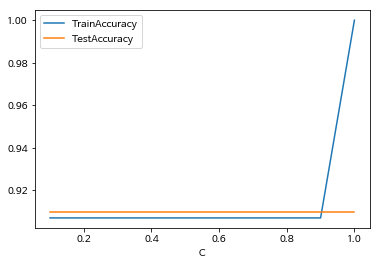

In [15]:
# C별 정확도 테이블
ds_accuracy1.round(3)
# C 별 정확도 그래프로 확인
ds_accuracy1.set_index("C",inplace = False).plot.line()

In [ ]:
# train 및 테스트 정확도 결과 저장용
train_accuracy =  []
test_accuracy = []
para_gamma = []
# 트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for n_tree in range(n_iter_tree):QD
    rf1 = RandomForestClassifier(n_estimators=n_tree+1, random_state=1234)
    rf1.fit(ds_hmeq_train_x_scaled,ds_hmeq_train_y)
    train_accuracy.append(rf1.score(ds_hmeq_train_x_scaled,ds_hmeq_train_y))
    test_accuracy.append(rf1.score(ds_hmeq_test_x_scaled,ds_hmeq_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["NumberofTree"] = [n_tree + 1 for n_tree in range(n_iter_tree)]
ds_accuracy1["TrainAccuracy"]=train_accuracy
ds_accuracy1["TestAccuracy"]=test_accuracy